# **Исследование данных о звонках операторов продающих услуги компании**

In [26]:
from scipy import stats as st

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import plotly.express as px
from plotly import graph_objects as go

import re 
import math as mth

## Обзор данных

Посмотрим что находится в данных.

In [27]:
df = pd.read_csv("dataset.csv")

In [28]:
df

,task_rk,duratoin_sec,hit_status_result_desc,hid,using_flg,agent_login
0,196,"55,66","Дозвон, Перезвонить",1,NaN,1190lasa
1,630,0,Недозвон,4,NaN,zovadxta
2,630,0,Недозвон,4,NaN,lovaraka
3,852,189,"Дозвон, Перезвонить",1,NaN,7876nssh
4,1635,0,Недозвон,4,NaN,inovgaan
...,...,...,...,...,...,...
89169,99997999,0,Недозвон,1,NaN,9363vesh
89170,99998332,"103,88","Дозвон, Перезвонить",4,NaN,ayanyuyu
89171,99998332,0,Недозвон,4,NaN,vkiniyua
89172,99999355,"32,78","Дозвон, Отказ",4,NaN,oyansgat


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89174 entries, 0 to 89173
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   task_rk                 89174 non-null  int64  
 1   duratoin_sec            89174 non-null  object 
 2   hit_status_result_desc  89174 non-null  object 
 3   hid                     89174 non-null  int64  
 4   using_flg               2525 non-null   float64
 5   agent_login             89174 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 4.1+ MB


In [30]:
df.hit_status_result_desc.value_counts()

Недозвон                                  50461
Дозвон, Отказ                             18459
Дозвон, Перезвонить                       15108
Дозвон, Успешно                            3310
Дозвон, Отложить                           1680
Не было звонка                              130
Дозвон, Некорректное задание по звонку       26
Name: hit_status_result_desc, dtype: int64

---
## Подготовка данных

Заменим названия столбцов

In [31]:
df.columns = ["task_id", "duration_sec", "result", "product_id", "using", "agent_login"]
df.head(2)

,task_id,duration_sec,result,product_id,using,agent_login
0,196,"55,66","Дозвон, Перезвонить",1,NaN,1190lasa
1,630,0,Недозвон,4,NaN,zovadxta


Теперь названия столбцов стали понятнее
* `task_id` — идентификатор задания;
* `duratoin_sec` — продолжительность звонка;
* `result` — результата коммуникации;
* `product_id` — идентификатор продукта;
* `using` — флаг начала пользования продуктом;
* `agent_login` — логин оператора.

Заменим тип данных в `duration_sec`

In [32]:
# Функция заменяет ',' на '.' и переведет во float
def replace_comma(dur):
    nw = []
    for i in dur:
        i = float(i.replace(",","."))
        nw.append(i)
    return nw

In [33]:
df["duration_sec"] = replace_comma(df["duration_sec"])


Проверим пропуски

In [34]:
# подсчёт пропусков
df.isna().sum()

task_id             0
duration_sec        0
result              0
product_id          0
using           86649
agent_login         0
dtype: int64

В нашем случае, пропуски в `using` показывают что в клиент ещё не дошел до продукта, чтобы принять решение по его ипользованию.

Проверим дупликаты

In [35]:
print('Кол-во дубликатов =',df.duplicated(["task_id", "duration_sec", "result", "product_id", "using", "agent_login"]).sum())

Кол-во дубликатов = 402


*402 дубликатов, скорей всего эти дубликаты являются попытками оператора дозвонится до клиента и их можно спокойно удалить. Но сначала посмотрим что там:*

In [36]:
df[df.duplicated()==True].sort_values(by=["task_id", "duration_sec", "result", "product_id", "using", "agent_login"]).head(30)

,task_id,duration_sec,result,product_id,using,agent_login
231,62937,0.0,Недозвон,1,NaN,8843evod
593,169912,0.0,Недозвон,4,NaN,eevaanom
707,205167,0.0,Недозвон,4,NaN,kovantta
741,214203,0.0,Недозвон,1,NaN,2415aaty
837,248928,0.0,Недозвон,4,NaN,uluuinnu
881,265455,0.0,Недозвон,4,NaN,eevaanom
1824,587280,0.0,Недозвон,4,NaN,ryannaxa
1831,587651,0.0,Недозвон,4,NaN,6691agsa
1889,606326,0.0,Недозвон,2,NaN,5596avlo
1895,607704,0.0,Недозвон,4,NaN,2238aagr


In [37]:
df[(df["task_id"]==62937) & (df["result"]=="Недозвон")]

,task_id,duration_sec,result,product_id,using,agent_login
228,62937,0.0,Недозвон,1,NaN,kovaevsk
229,62937,0.0,Недозвон,1,NaN,8843evod
231,62937,0.0,Недозвон,1,NaN,8843evod
232,62937,0.0,Недозвон,1,NaN,tovaarbo


Видно, что одни и те же действия, по тем же заданиям, с тем же результатами повторяются. Удалим их:

In [38]:
df = df.drop_duplicates()
print('Кол-во оставшихся дубликатов =', df.duplicated().sum())

Кол-во оставшихся дубликатов = 0


Проверим:

In [39]:
print('Было строчек - 89174 /', "удалили дубликатов - 402", "Осталось строк -", (89174-402))

Было строчек - 89174 / удалили дубликатов - 402 Осталось строк - 88772


In [40]:
df = df.reset_index(drop=True)
df

,task_id,duration_sec,result,product_id,using,agent_login
0,196,55.66,"Дозвон, Перезвонить",1,NaN,1190lasa
1,630,0.00,Недозвон,4,NaN,zovadxta
2,630,0.00,Недозвон,4,NaN,lovaraka
3,852,189.00,"Дозвон, Перезвонить",1,NaN,7876nssh
4,1635,0.00,Недозвон,4,NaN,inovgaan
...,...,...,...,...,...,...
88767,99997999,0.00,Недозвон,1,NaN,9363vesh
88768,99998332,103.88,"Дозвон, Перезвонить",4,NaN,ayanyuyu
88769,99998332,0.00,Недозвон,4,NaN,vkiniyua
88770,99999355,32.78,"Дозвон, Отказ",4,NaN,oyansgat


*Всё сходится 88772 строк.*

*Вывод. Таблица готова для анализа.*

In [41]:
print('Кол-во успешных звонков =', df[df["duration_sec"]!=0]["duration_sec"].count())
sum = 0
for g in ["Дозвон, Отказ", "Дозвон, Перезвонить","Дозвон, Успешно","Дозвон, Отложить","Дозвон, Некорректное задание по звонку"]:
    users_gr = df[df["result"]==g]["result"].count()
    sum += users_gr
    print(f'Результат {g} — {users_gr} кол-во звонков')
print(f'При сложениии получается — {sum} дозвонов')

Кол-во успешных звонков = 38523
Результат Дозвон, Отказ — 18459 кол-во звонков
Результат Дозвон, Перезвонить — 15108 кол-во звонков
Результат Дозвон, Успешно — 3305 кол-во звонков
Результат Дозвон, Отложить — 1680 кол-во звонков
Результат Дозвон, Некорректное задание по звонку — 26 кол-во звонков
При сложениии получается — 38578 дозвонов


*Звонков с продолжительностью больше 0 меньше суммы всех дозвонов. Получается, что дозвоном считается звонок который клиент  отклонил*

In [42]:
df["result"].value_counts()

Недозвон                                  50064
Дозвон, Отказ                             18459
Дозвон, Перезвонить                       15108
Дозвон, Успешно                            3305
Дозвон, Отложить                           1680
Не было звонка                              130
Дозвон, Некорректное задание по звонку       26
Name: result, dtype: int64

In [43]:
df[(df["duration_sec"]==0) & (df["result"]=="Дозвон, Успешно")].head(5)

,task_id,duration_sec,result,product_id,using,agent_login
4166,1561170,0.0,"Дозвон, Успешно",4,0.0,cyanrser
4778,1755964,0.0,"Дозвон, Успешно",4,0.0,cyanrser
8747,3097008,0.0,"Дозвон, Успешно",4,0.0,cyanrser
8878,3139115,0.0,"Дозвон, Успешно",4,0.0,cyanrser
10804,3920798,0.0,"Дозвон, Успешно",4,0.0,cyanrser


# Изучиние и проверка данных

Количество уникальных заданий:

In [44]:
task = df["task_id"].nunique()
print("Заданий в таблице:", task)

Заданий в таблице: 50000


Количество операторов

In [45]:
agent = df["agent_login"].nunique()
print("Операторов в таблице:", agent)

Операторов в таблице: 1962


Среднее количество заданий на оператора

In [46]:
print("Среднее кол-во заданий на оператора =", round((task / agent), 1))

Среднее кол-во заданий на оператора = 25.5


Распределение количества заданий на операторов

In [47]:
event_per_user = df.groupby("agent_login")["task_id"].count()
event_per_user.describe()

count    1962.000000
mean       45.245668
std        32.836464
min         1.000000
25%        19.000000
50%        39.000000
75%        66.000000
max       184.000000
Name: task_id, dtype: float64

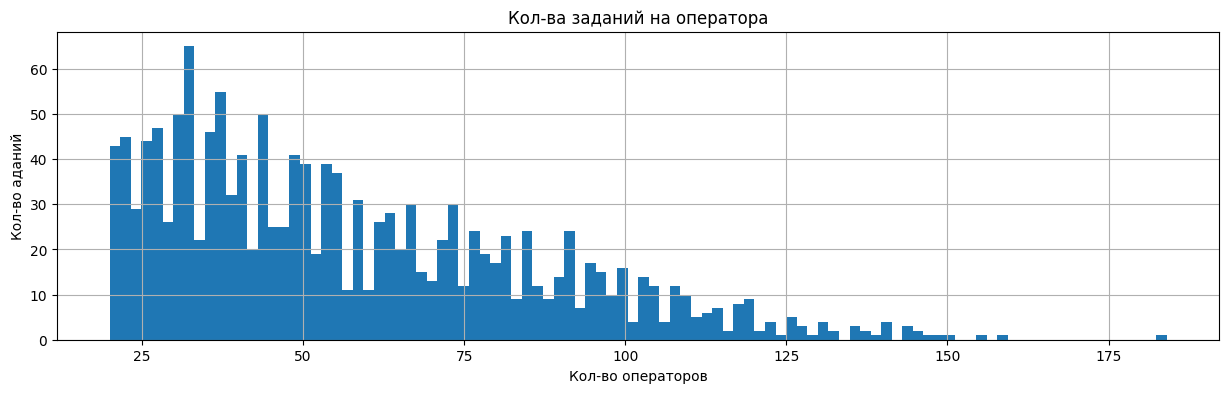

In [48]:
plt.figure(figsize=(15,4))
plt.hist(event_per_user, bins=100, range=(20,184)) 
plt.xlabel("Кол-во операторов")
plt.grid()
plt.ylabel("Кол-во аданий")
plt.title("Кол-ва заданий на оператора");

## Изучение воронки продаж

Посмотрим, какие исходы есть в логах, как часто они встречаются

In [49]:
fig = go.Figure(data=[go.Pie(labels=df['result'].value_counts().index, values=df['result'].value_counts(), \
                             title='Доли событий')])
fig.show()

*Больше половины (56.4%) исходов это - "Недозвон", вторая половина это другие 6 событий: "Дозвон, Отказ" (20.8%), "Дозвон, Перезвонить" (17%), "Дозвон, Успешно" (3.72%) и "Дозвон, Отложить" (1.89%). Остальное - "Не было звонка" (0,15%) и "Дозвон, Некорректное задание по звонку" (0.03%), почти незаметно, им похоже можно пренебречь в будущем, к тому же какую пользу можно извлечь из этой информации пока не понятно.*